In [1]:
%matplotlib inline
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import optuna

In [2]:
application_df = pd.read_csv('../data/org/application_train.csv')

In [3]:
categorical_cols = []

for col in application_df.columns:
    if application_df[col].dtypes == object:
        categorical_cols.append(col)
    if application_df[col].dtypes == int or application_df[col].dtypes == float:
        application_df[col] = application_df[col].fillna(application_df[col].mean())

In [4]:
application_df_dummy = pd.get_dummies(application_df, columns=categorical_cols)
application_df_dummy.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# feature_importanceを出しながらプロットまでする関数たち

def get_feature_importance(df, target_col, model):
    df_pos = df[df[target_col]==1].iloc[:20000,:]
    df_neg = df[df[target_col]==0].sample(frac=1).iloc[:20000,:]
    
    df_combined = pd.concat([df_pos, df_neg], axis=0)
    df_train, df_eval = train_test_split(df_combined, test_size=0.2, random_state=0)
    train_X, train_y = df_train.iloc[:,2:], df_train.iloc[:,1]
    eval_X, eval_y = df_eval.iloc[:,2:], df_eval.iloc[:,1]

    model.fit(train_X, train_y)
    pred_y = model.predict(eval_X)
    print('AUC: {}'.format(roc_auc_score(eval_y, pred_y)))
    print('Accuracy: {}'.format(accuracy_score(eval_y, pred_y)))
    
    col_names = train_X.columns
    importances = model.feature_importances_    
    plot_feature_importance(col_names, importances)
    
    f_importance_array = np.concatenate([np.array(col_names).reshape(-1,1),importances.reshape(-1,1)], axis=1)
    
    return pd.DataFrame(f_importance_array, columns=['col_name', 'importance'])
    
    
def plot_feature_importance(col_names, importances):
    indices = np.argsort(importances)
    plt.figure(figsize=(10,100))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), col_names[indices])
    plt.show()

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=20190622)


In [7]:
# 寄与度が高いものの正体のわからないカラムを除く
application_df_dummy_replace = application_df_dummy.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)


AUC: 0.6282761282761283
Accuracy: 0.62825


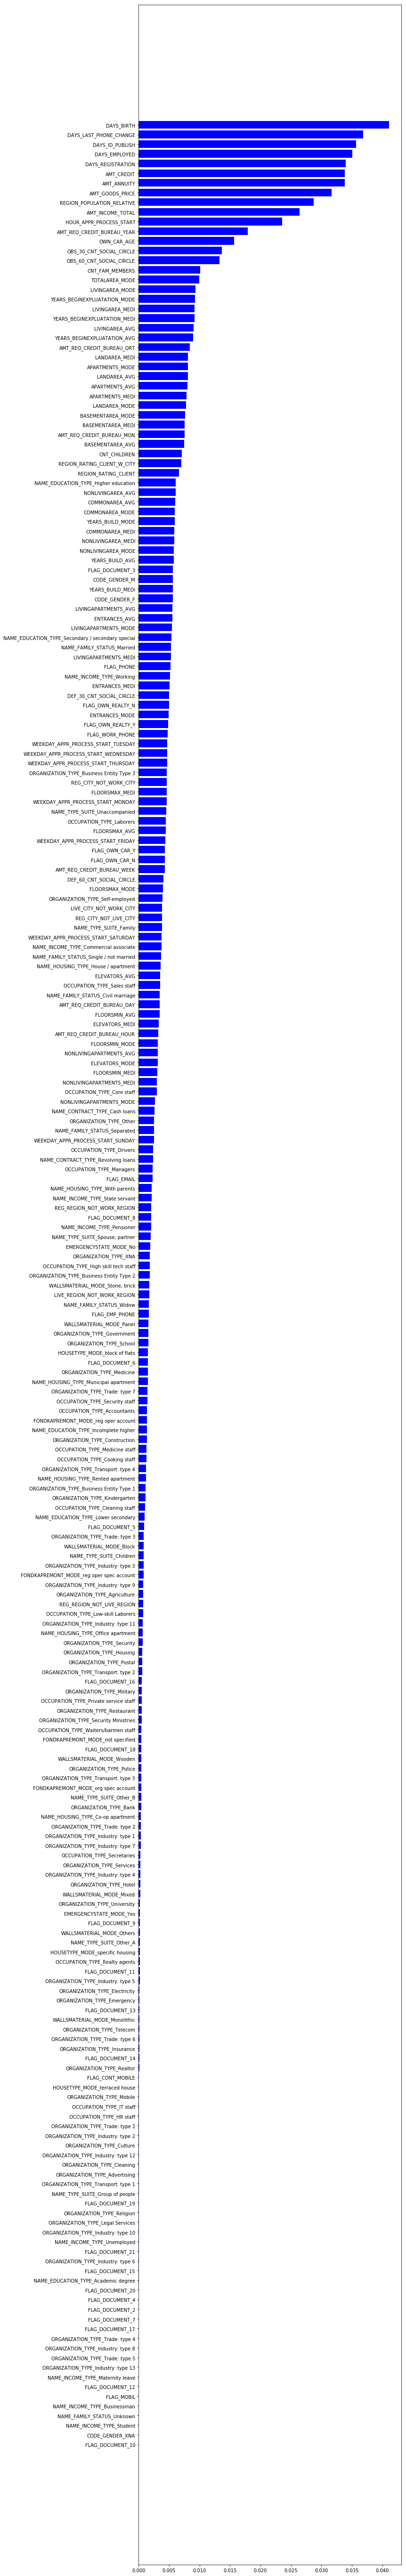

,col_name,importance
6,DAYS_BIRTH,0.0410707
74,DAYS_LAST_PHONE_CHANGE,0.036842
9,DAYS_ID_PUBLISH,0.0356912
7,DAYS_EMPLOYED,0.0350506
8,DAYS_REGISTRATION,0.0340157
2,AMT_CREDIT,0.033847
3,AMT_ANNUITY,0.0338076
4,AMT_GOODS_PRICE,0.0316708
5,REGION_POPULATION_RELATIVE,0.0287145
1,AMT_INCOME_TOTAL,0.0264106


In [8]:
col_importances = get_feature_importance(df=application_df_dummy_replace, target_col='TARGET', model=rf_model)
col_importances.sort_values('importance', ascending=False).iloc[:20,:]


In [9]:
# 使用するカラムをfeature_importancesの上位20個に限定
USE_COLUMNS = col_importances.sort_values('importance', ascending=False).iloc[:20,:].col_name.unique()
USE_COLUMNS = USE_COLUMNS.tolist()
USE_COLUMNS.append('TARGET')
USE_COLUMNS


['DAYS_BIRTH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'CNT_FAM_MEMBERS',
 'TOTALAREA_MODE',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'LIVINGAREA_MEDI',
 'TARGET']

In [10]:
experiment_df = application_df_dummy[USE_COLUMNS]

In [11]:
def split_dataset(df, target_col, is_train=True):
    '''
    正例・負例のバランスを整えながら分割する関数
    '''
    df_pos = df[df[target_col]==1].iloc[:20000,:]
    df_neg = df[df[target_col]==0].sample(frac=1).iloc[:20000,:]
    
    df_combined = pd.concat([df_pos, df_neg], axis=0)
    df_train, df_eval = train_test_split(df_combined, test_size=0.2, random_state=0)
    train_X, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
    eval_X, eval_y = df_eval.iloc[:,:-1], df_eval.iloc[:,-1]
    return train_X, eval_X, train_y, eval_y


In [12]:
train_X, eval_X, train_y, eval_y = split_dataset(experiment_df, target_col='TARGET')

In [13]:
before_params = {
         'eta':0.5,
         'gamma':0.2,
         'lambda':0.2,
         'alpha':0.5,
         'max_depth':10,
         'min_child_weight':1,
         'subsample':0.5,
         'objective':'reg:linear',
         'booster':'gbtree',
         'base_score':3
         }

dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(eval_X, label=eval_y)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
xgb_model = xgb.train(before_params, dtrain, 500,
                      evals=watchlist,
                      verbose_eval=True)

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:1.34336	train-rmse:1.3432
[1]	eval-rmse:0.796577	train-rmse:0.789585
[2]	eval-rmse:0.585727	train-rmse:0.567887
[3]	eval-rmse:0.520008	train-rmse:0.492398
[4]	eval-rmse:0.505173	train-rmse:0.464559
[5]	eval-rmse:0.503304	train-rmse:0.450333
[6]	eval-rmse:0.505492	train-rmse:0.442575
[7]	eval-rmse:0.50777	train-rmse:0.437372
[8]	eval-rmse:0.508826	train-rmse:0.434169
[9]	eval-rmse:0.511475	train-rmse:0.427666
[10]	eval-rmse:0.51309	train-rmse:0.425225
[11]	eval-rmse:0.515426	train-rmse:0.419099
[12]	eval-rmse:0.517005	train-rmse:0.413055
[13]	eval-rmse:0.519314	train-rmse:0.408583
[14]	eval-rmse:0.523306	train-rmse:0.403127
[15]	eval-rmse:0.526114	train-rmse:0.398975
[16]	eval-rmse:0.529307	train-rmse:0.395304
[17]	eval-rmse:0.532612	train-rmse:0.390714
[18]	eval-rmse:0.535406	train-rmse:0.385298
[19]	eval-rmse:0.536205	train-rmse:0.381744
[20]	eval-rmse:0.537443	train-rmse:0.377728
[21]	eval-rmse:0.538701	train-rmse:0.374691
[22]	eval-rmse:0.539371	train-rmse:0.37309
[23]

[186]	eval-rmse:0.616101	train-rmse:0.159626
[187]	eval-rmse:0.616266	train-rmse:0.159333
[188]	eval-rmse:0.616184	train-rmse:0.159001
[189]	eval-rmse:0.616216	train-rmse:0.158706
[190]	eval-rmse:0.616228	train-rmse:0.158595
[191]	eval-rmse:0.616277	train-rmse:0.15843
[192]	eval-rmse:0.616106	train-rmse:0.158237
[193]	eval-rmse:0.6163	train-rmse:0.158114
[194]	eval-rmse:0.61626	train-rmse:0.157782
[195]	eval-rmse:0.616294	train-rmse:0.157637
[196]	eval-rmse:0.616304	train-rmse:0.157386
[197]	eval-rmse:0.616409	train-rmse:0.157298
[198]	eval-rmse:0.616379	train-rmse:0.157197
[199]	eval-rmse:0.616349	train-rmse:0.156982
[200]	eval-rmse:0.616324	train-rmse:0.156922
[201]	eval-rmse:0.61653	train-rmse:0.156703
[202]	eval-rmse:0.616624	train-rmse:0.156508
[203]	eval-rmse:0.616675	train-rmse:0.156361
[204]	eval-rmse:0.616777	train-rmse:0.156221
[205]	eval-rmse:0.616848	train-rmse:0.156125
[206]	eval-rmse:0.61677	train-rmse:0.155902
[207]	eval-rmse:0.616856	train-rmse:0.155703
[208]	eval-rmse:

[370]	eval-rmse:0.618422	train-rmse:0.142088
[371]	eval-rmse:0.618472	train-rmse:0.142066
[372]	eval-rmse:0.618498	train-rmse:0.142001
[373]	eval-rmse:0.618481	train-rmse:0.141919
[374]	eval-rmse:0.6186	train-rmse:0.141774
[375]	eval-rmse:0.618586	train-rmse:0.141636
[376]	eval-rmse:0.618562	train-rmse:0.141609
[377]	eval-rmse:0.618606	train-rmse:0.141509
[378]	eval-rmse:0.618605	train-rmse:0.141509
[379]	eval-rmse:0.618578	train-rmse:0.141508
[380]	eval-rmse:0.618577	train-rmse:0.141508
[381]	eval-rmse:0.61853	train-rmse:0.141475
[382]	eval-rmse:0.618521	train-rmse:0.141336
[383]	eval-rmse:0.618478	train-rmse:0.1413
[384]	eval-rmse:0.618453	train-rmse:0.141306
[385]	eval-rmse:0.618465	train-rmse:0.141223
[386]	eval-rmse:0.618441	train-rmse:0.141155
[387]	eval-rmse:0.61844	train-rmse:0.141154
[388]	eval-rmse:0.618439	train-rmse:0.141154
[389]	eval-rmse:0.618376	train-rmse:0.141087
[390]	eval-rmse:0.618457	train-rmse:0.141059
[391]	eval-rmse:0.618457	train-rmse:0.141058
[392]	eval-rmse:

In [15]:
# スコア確認
pred_y = xgb_model.predict(dvalid, ntree_limit=xgb_model.best_iteration + 1)
score = roc_auc_score(eval_y, pred_y)
print('AUC before hp-tuning: {}'.format(score))


AUC before hp-tuning: 0.5762164512164513


In [28]:
# 一旦スコア出したい
USE_COLUMNS_TEST = USE_COLUMNS.copy()
USE_COLUMNS_TEST.pop(-1)

test_df = pd.read_csv('../data/org/application_test.csv')
test_df = pd.get_dummies(test_df, columns=categorical_cols)
test_X = test_df[USE_COLUMNS_TEST]

dtest = xgb.DMatrix(test_X)
pred_y = xgb_model.predict(dtest, ntree_limit=xgb_model.best_iteration + 1)
submission_df = pd.concat([test_df.loc[:,'SK_ID_CURR'], pd.DataFrame(pred_y)], axis=1)


In [29]:
submission_df.to_csv('submission.csv', index=None)

In [30]:
def opt(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 0, 1000),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'eta': trial.suggest_discrete_uniform('gamma', 0.25, 0.5, 0.025),
    'gamma': trial.suggest_discrete_uniform('gamma', 0.5, 1, 0.05),
    'lambda': trial.suggest_discrete_uniform('lambda', 0.025, 1.0, 0.05),
    'alpha': trial.suggest_discrete_uniform('alpha', 0.1, 0.8, 0.05),
    'max_depth':  trial.suggest_int('max_depth', 1, 14),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
    'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
    'random_state': 0
    }
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    # 変数の格納
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dvalid = xgb.DMatrix(eval_X, label=eval_y)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    xgb_model = xgb.train(before_params, dtrain, 200,
                          evals=watchlist,
                          verbose_eval=True)
    pred_y = xgb_model.predict(dvalid, ntree_limit=xgb_model.best_iteration + 1)
    score = roc_auc_score(eval_y, pred_y)
    print("\tScore {0}\n\n".format(score))
    return -1 * score

In [ ]:
# 最適化
study = optuna.create_study()
study.optimize(opt, n_trials=100)

[W 2019-06-22 08:03:31,875] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-06-22 08:03:31,898] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-06-22 08:03:31,909] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-06-22 08:03:31,916] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 418, 'max_depth': 15, 'eta': 0.475, 'gamma': 0.475, 'lambda': 0.525, 'alpha': 0.2, 'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 0.6, 'random_state': 0}


/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:1.34336	train-rmse:1.3432
[1]	eval-rmse:0.796577	train-rmse:0.789585
[2]	eval-rmse:0.585727	train-rmse:0.567887
[3]	eval-rmse:0.520008	train-rmse:0.492398
[4]	eval-rmse:0.505173	train-rmse:0.464559
[5]	eval-rmse:0.503304	train-rmse:0.450333
[6]	eval-rmse:0.505492	train-rmse:0.442575
[7]	eval-rmse:0.50777	train-rmse:0.437372
[8]	eval-rmse:0.508826	train-rmse:0.434169
[9]	eval-rmse:0.511475	train-rmse:0.427666
[10]	eval-rmse:0.51309	train-rmse:0.425225
[11]	eval-rmse:0.515426	train-rmse:0.419099
[12]	eval-rmse:0.517005	train-rmse:0.413055
[13]	eval-rmse:0.519314	train-rmse:0.408583
[14]	eval-rmse:0.523306	train-rmse:0.403127
[15]	eval-rmse:0.526114	train-rmse:0.398975
[16]	eval-rmse:0.529307	train-rmse:0.395304
[17]	eval-rmse:0.532612	train-rmse:0.390714
[18]	eval-rmse:0.535406	train-rmse:0.385298
[19]	eval-rmse:0.536205	train-rmse:0.381744
[20]	eval-rmse:0.537443	train-rmse:0.377728
[21]	eval-rmse:0.538701	train-rmse:0.374691
[22]	eval-rmse:0.539371	train-rmse:0.37309
[23]

[186]	eval-rmse:0.616101	train-rmse:0.159626
[187]	eval-rmse:0.616266	train-rmse:0.159333
[188]	eval-rmse:0.616184	train-rmse:0.159001
[189]	eval-rmse:0.616216	train-rmse:0.158706
[190]	eval-rmse:0.616228	train-rmse:0.158595
[191]	eval-rmse:0.616277	train-rmse:0.15843
[192]	eval-rmse:0.616106	train-rmse:0.158237
[193]	eval-rmse:0.6163	train-rmse:0.158114
[194]	eval-rmse:0.61626	train-rmse:0.157782
[195]	eval-rmse:0.616294	train-rmse:0.157637
[196]	eval-rmse:0.616304	train-rmse:0.157386
[197]	eval-rmse:0.616409	train-rmse:0.157298
[198]	eval-rmse:0.616379	train-rmse:0.157197
[199]	eval-rmse:0.616349	train-rmse:0.156982
	Score 0.576149044899045




[I 2019-06-22 08:03:50,311] Finished trial#0 resulted in value: -0.576149044899045. Current best value is -0.576149044899045 with parameters: {'n_estimators': 418, 'max_depth': 15, 'gamma': 0.475, 'lambda': 0.525, 'alpha': 0.2, 'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 0.6}.
[W 2019-06-22 08:03:50,321] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-06-22 08:03:50,327] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-06-22 08:03:50,330] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-06-22 08:03:50,334] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 570, 'max_depth': 10, 'eta': 0.45, 'gamma': 0.45, 'lambda': 0.525, 'alpha': 0.1, 'min_child_weight': 12, 'subsample': 0.8, 'colsample_bytree': 0.5, 'random_state': 0}


/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:1.34336	train-rmse:1.3432
[1]	eval-rmse:0.796577	train-rmse:0.789585
[2]	eval-rmse:0.585727	train-rmse:0.567887
[3]	eval-rmse:0.520008	train-rmse:0.492398
[4]	eval-rmse:0.505173	train-rmse:0.464559
[5]	eval-rmse:0.503304	train-rmse:0.450333
[6]	eval-rmse:0.505492	train-rmse:0.442575
[7]	eval-rmse:0.50777	train-rmse:0.437372
[8]	eval-rmse:0.508826	train-rmse:0.434169
[9]	eval-rmse:0.511475	train-rmse:0.427666
[10]	eval-rmse:0.51309	train-rmse:0.425225
[11]	eval-rmse:0.515426	train-rmse:0.419099
[12]	eval-rmse:0.517005	train-rmse:0.413055
[13]	eval-rmse:0.519314	train-rmse:0.408583
[14]	eval-rmse:0.523306	train-rmse:0.403127
[15]	eval-rmse:0.526114	train-rmse:0.398975
[16]	eval-rmse:0.529307	train-rmse:0.395304
[17]	eval-rmse:0.532612	train-rmse:0.390714
[18]	eval-rmse:0.535406	train-rmse:0.385298
[19]	eval-rmse:0.536205	train-rmse:0.381744
[20]	eval-rmse:0.537443	train-rmse:0.377728
[21]	eval-rmse:0.538701	train-rmse:0.374691
[22]	eval-rmse:0.539371	train-rmse:0.37309
[23]

[186]	eval-rmse:0.616101	train-rmse:0.159626
[187]	eval-rmse:0.616266	train-rmse:0.159333
[188]	eval-rmse:0.616184	train-rmse:0.159001
[189]	eval-rmse:0.616216	train-rmse:0.158706
[190]	eval-rmse:0.616228	train-rmse:0.158595
[191]	eval-rmse:0.616277	train-rmse:0.15843
[192]	eval-rmse:0.616106	train-rmse:0.158237
[193]	eval-rmse:0.6163	train-rmse:0.158114
[194]	eval-rmse:0.61626	train-rmse:0.157782
[195]	eval-rmse:0.616294	train-rmse:0.157637
[196]	eval-rmse:0.616304	train-rmse:0.157386
[197]	eval-rmse:0.616409	train-rmse:0.157298
[198]	eval-rmse:0.616379	train-rmse:0.157197
[199]	eval-rmse:0.616349	train-rmse:0.156982
	Score 0.576149044899045




[I 2019-06-22 08:04:04,530] Finished trial#1 resulted in value: -0.576149044899045. Current best value is -0.576149044899045 with parameters: {'n_estimators': 418, 'max_depth': 15, 'gamma': 0.475, 'lambda': 0.525, 'alpha': 0.2, 'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 0.6}.
[W 2019-06-22 08:04:04,541] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.25, 0.475].
[W 2019-06-22 08:04:04,544] The range of parameter `gamma` is not divisible by `q`, and is replaced by [0.5, 0.95].
[W 2019-06-22 08:04:04,547] The range of parameter `lambda` is not divisible by `q`, and is replaced by [0.025, 0.9750000000000001].
[W 2019-06-22 08:04:04,550] The range of parameter `alpha` is not divisible by `q`, and is replaced by [0.1, 0.8].


Training with params: 
{'n_estimators': 992, 'max_depth': 14, 'eta': 0.25, 'gamma': 0.25, 'lambda': 0.07500000000000001, 'alpha': 0.1, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.9, 'random_state': 0}


/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-rmse:1.34336	train-rmse:1.3432
[1]	eval-rmse:0.796577	train-rmse:0.789585
[2]	eval-rmse:0.585727	train-rmse:0.567887
[3]	eval-rmse:0.520008	train-rmse:0.492398
[4]	eval-rmse:0.505173	train-rmse:0.464559
[5]	eval-rmse:0.503304	train-rmse:0.450333
[6]	eval-rmse:0.505492	train-rmse:0.442575
[7]	eval-rmse:0.50777	train-rmse:0.437372
[8]	eval-rmse:0.508826	train-rmse:0.434169
[9]	eval-rmse:0.511475	train-rmse:0.427666
[10]	eval-rmse:0.51309	train-rmse:0.425225
[11]	eval-rmse:0.515426	train-rmse:0.419099
[12]	eval-rmse:0.517005	train-rmse:0.413055
[13]	eval-rmse:0.519314	train-rmse:0.408583
[14]	eval-rmse:0.523306	train-rmse:0.403127
[15]	eval-rmse:0.526114	train-rmse:0.398975
[16]	eval-rmse:0.529307	train-rmse:0.395304
[17]	eval-rmse:0.532612	train-rmse:0.390714
[18]	eval-rmse:0.535406	train-rmse:0.385298
[19]	eval-rmse:0.536205	train-rmse:0.381744
[20]	eval-rmse:0.537443	train-rmse:0.377728
[21]	eval-rmse:0.538701	train-rmse:0.374691
[22]	eval-rmse:0.539371	train-rmse:0.37309
[23]

In [ ]:
# ベストなハイパーパラメータを使って再度学習
best_hyperparams = study.best_params

dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(eval_X, label=eval_y)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

xgb_model = xgb.train(best_hyperparams, dtrain, 500,
                      evals=watchlist,
                      verbose_eval=True)

In [ ]:
pred_y = xgb_model.predict(dvalid, ntree_limit=xgb_model.best_iteration + 1)
score = roc_auc_score(eval_y, pred_y)

In [ ]:
print(score)

In [ ]:
# スコア出したい
dtest = xgb.DMatrix(test_X)
pred_y = xgb_model.predict(dtest, ntree_limit=xgb_model.best_iteration + 1)
submission_df.to_csv('submission_second.csv', index=None)


In [ ]:
def eliminate_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    '''
    外れ値を除外するための関数
    
    Parameters
    -----------------
    df: pd.DataFrame
        元のデータフレーム
    target: string
        対象のカラム名
        
    Return
    -----------------
    df_after: pd.DataFrame
        対象のカラムのうち外れ値（平均+(2*標準偏差)を超えた値）を除いたデータフレーム
    '''
    target_limit = np.average(df[target]) + 2*np.std(df[target])
    df_after = df[df[target] < target_limit]
    query = target + ' < @target_limit'
    
    print("外れ値除去後のデータの割合:")
    print("{:.3f}%".format(len(df_after.query(query))/len(df)*100))    
    
    return df_after

In [ ]:
def plot_histgrams(df: pd.DataFrame, targets: List[str], figsize=(15,8)):
    '''
    指定したカラム名に基づいたヒストグラム・散布図を作成してくれる関数
    軸の都合上外れ値を除いている
    
    Parameters
    -----------------
    df: pd.DataFrame
        グラフ作成対象のデータフレーム
    target: List
        図示したい対象のカラム名のリスト
        ヒストグラムの場合は一つ、散布図の場合は二つ入る
    plot_type: str
        図示のタイプ。{'hist', 'scatter'}から選択
    figsize: Tuple
        グラフサイズの大きさ
    
    Return
    -----------------
    None
    '''
    fig, ax = plt.subplots(len(targets),1, figsize=figsize)
    
    for i, target_col in enumerate(targets):
        # NULLの除外
        print('num of NULL records: {}'.format(df[target_col].isnull().sum()))
        df = df.dropna(subset=target)
        # 外れ値の除外
        df = eliminate_outliers(df, target_col)
        
        ax[i].hist(df.loc[:,target_col], bins=100)
        ax[i].set_xlim(df[target_col].min(), df[target_col].max())


In [ ]:
target_columns = USE_COLUMNS.copy()
target_columns.pop('TARGET')
plot_histgrams(df=application_df_dummy_replace, targets=target_columns)
